# Week 3 Seminar

Collaborative Filtering recommender

In [21]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

In [22]:
DATA_DIR = "/Users/darya.nikanorova/recsys_course/seminar_03/"

In [23]:
data = pd.read_json(DATA_DIR + "data.json", lines=True).drop_duplicates(subset=["user", "track"])

In [25]:
positives = data[data["time"] > 0.8].copy()
positives["test"] = np.random.random(len(positives)) >= 0.7

In [26]:
user_counts = positives[~positives["test"]].groupby("user").size()
users = set(user_counts[user_counts >= 5].index.values)

In [ ]:
track_counts = positives[~positives["test"]].groupby("track").size()
tracks = set(track_counts[track_counts >= 5].index.values)

## Train LightFM

In [27]:
train_data = positives[~positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]
test_data = positives[positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]

len(train_data), len(test_data)

(47057, 16492)

In [28]:
dataset = ld.Dataset()
dataset.fit(users, tracks)

In [29]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [30]:
def fit_model(epochs=1, at=10, loss="warp", no_components=30, learning_rate=0.01, max_sampled=10, user_alpha=0.0, item_alpha=0.0, threads=30, verbose=False):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    precisions_at = []
    
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
        precisions_at.append(np.mean(precision_at))
        
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.0001])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.0001])
    
    model, precisions_at = fit_model(
        epochs=5, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]

In [31]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
best_params = study.best_params

[I 2022-06-09 21:17:02,121] A new study created in memory with name: no-name-983ea872-f6c1-4215-964d-9e6f1e2f0356
[I 2022-06-09 21:17:09,865] Trial 0 finished with value: 0.0005541701102629304 and parameters: {'loss': 'bpr', 'no_components': 10, 'learning_rate': 0.01, 'max_sampled': 100, 'user_alpha': 0.0001, 'item_alpha': 0.0001}. Best is trial 0 with value: 0.0005541701102629304.
[I 2022-06-09 21:17:17,499] Trial 1 finished with value: 0.001898032845929265 and parameters: {'loss': 'warp', 'no_components': 10, 'learning_rate': 0.0001, 'max_sampled': 20, 'user_alpha': 0.0001, 'item_alpha': 0.0}. Best is trial 1 with value: 0.001898032845929265.
[I 2022-06-09 21:17:29,177] Trial 2 finished with value: 0.0076198396272957325 and parameters: {'loss': 'warp', 'no_components': 30, 'learning_rate': 0.01, 'max_sampled': 100, 'user_alpha': 0.0, 'item_alpha': 0.0}. Best is trial 2 with value: 0.0076198396272957325.
[I 2022-06-09 21:17:40,996] Trial 3 finished with value: 0.006650041788816452 and

In [32]:
best_params

{'loss': 'warp',
 'no_components': 30,
 'learning_rate': 0.01,
 'max_sampled': 100,
 'user_alpha': 0.0,
 'item_alpha': 0.0}

In [ ]:
best_params = {'loss': 'warp',
 'no_components': 50,
 'learning_rate': 0.01,
 'max_sampled': 20,
 'user_alpha': 0.0,
 'item_alpha': 0.0}

In [33]:
model, precisions_at = fit_model(
    epochs=100,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.006012746132910252 +/- 0.0006298279901329524
1:	0.006082017440348864 +/- 0.0006347239169210811
2:	0.006386810448020697 +/- 0.0006526293827894393
3:	0.006691604852676392 +/- 0.0006699828402712587
4:	0.006940980441868305 +/- 0.0006892682841347364
5:	0.007578276097774506 +/- 0.0007304703001123361
6:	0.00839567743241787 +/- 0.0007753193700975897
7:	0.009310057386755943 +/- 0.0008153364115097842
8:	0.010072043165564537 +/- 0.0008465495938049539
9:	0.01102798618376255 +/- 0.0008883932561493445
10:	0.011762261390686035 +/- 0.0009100932962488494
11:	0.012787475250661373 +/- 0.0009512321445222445
12:	0.01390966959297657 +/- 0.0009830201958969031
13:	0.014782489277422428 +/- 0.0010129200055993457
14:	0.015669161453843117 +/- 0.0010418159214884365
15:	0.01655583269894123 +/- 0.0010674700879862388
16:	0.017345525324344635 +/- 0.001087210296348762
17:	0.01828761398792267 +/- 0.0011139358214868561
18:	0.019035745412111282 +/- 0.001131619083138587
19:	0.019673040136694908 +/- 0.00114592893155842

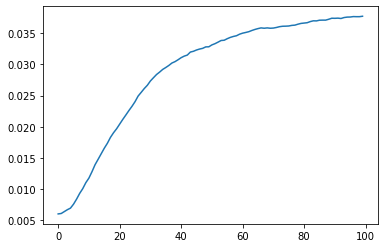

In [34]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

## Save track embeddings

In [35]:
biases, embeddings = model.get_item_representations()

In [ ]:
model.item_biases *= 0.0

In [36]:
track_meta = pd.read_json(DATA_DIR + "tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

In [37]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

In [38]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir=DATA_DIR + "tb")
writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)), tag="lightfm", metadata_header=["artist", "title"])
writer.close()

## Compute top recommendations

In [39]:
tracks = dataset_tracks["track"].values
users = [user for user, index in sorted(dataset.mapping()[0].items(), key=lambda kv: kv[1])]

In [40]:
with open(DATA_DIR + "recommendations.json", "w") as rf:
    for user_index in tqdm.tqdm(range(dataset.user_features_shape()[0])):
        predictions = model.predict(user_index, np.arange(dataset.item_features_shape()[0]), num_threads=30)
        top = tracks[np.argsort(predictions)[-100:]]
        recommendation = {
            "user": int(users[user_index]),
            "tracks": [int(x) for x in top]
        }
        rf.write(json.dumps(recommendation) + "\n")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8874/8874 [00:07<00:00, 1135.48it/s]
